In [20]:
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn.metrics as sm
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
import joblib

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

from utils import dar_estilo_visual, reporte_desempeno

In [2]:
dar_estilo_visual()

In [3]:
df = pd.read_csv('data\intermediate\df_modelo.csv')

In [4]:

objetivo = "clase"
X = df.drop(columns=objetivo)
y = df[objetivo]

In [5]:
seed = 42
# Partición train-test preservando la proporción de impagos en cada parte
X_train, X_test, y_train, y_test= train_test_split(X, y, 
                                                    stratify=y, # Con este parámetro se garantiza la divisón estratificada
                                                    test_size=0.15, # 15% de registros destinados para test
                                                    shuffle=True,
                                                    random_state= seed)

In [6]:

# Validación de que se preserva la proporción de impagos
prop_train = len(y_train[y_train==1]) / len(y_train)
prop_test = len(y_test[y_test==1]) / len(y_test) 
print("Proporcion de impagos en el conjunto de entrenamiento: {:.2f}".format(prop_train))
print("Proporción de impagos en el conjunto de prueba (test): {:.2f}".format(prop_test))

Proporcion de impagos en el conjunto de entrenamiento: 0.02
Proporción de impagos en el conjunto de prueba (test): 0.02


In [7]:
skf = StratifiedKFold(n_splits=5, 
                      random_state=seed, 
                      shuffle=True)

In [8]:
xg_params = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100,500],
}

tuned_xgboost = GridSearchCV(XGBClassifier(), 
                             param_grid=xg_params, 
                             cv=skf, 
                             scoring="recall")
tuned_xgboost.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'n_estimators': [100, 500]},
             scoring='recall')

In [9]:
tuned_xgboost.best_score_

0.7240601503759398

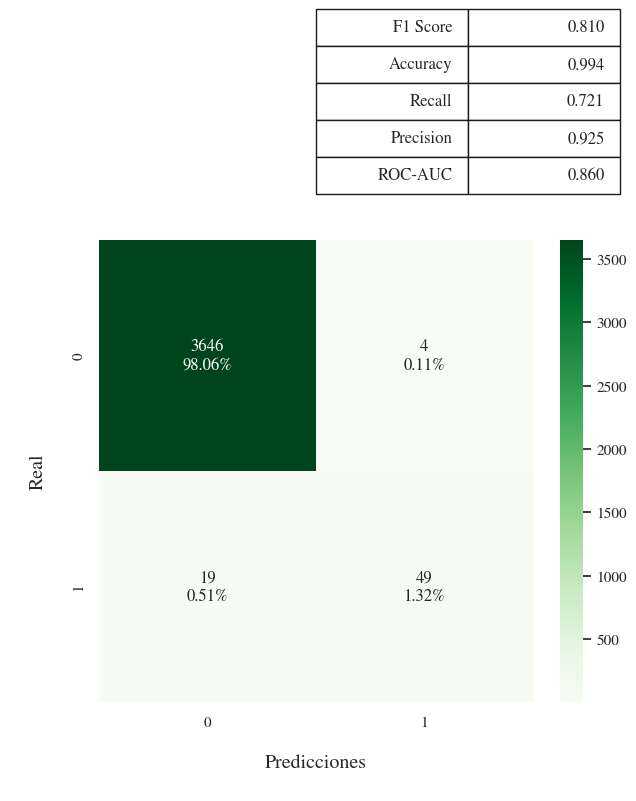

In [17]:
# Matriz de confusión
reporte_desempeno(y_test, tuned_xgboost.predict(X_test) )

In [40]:
y_pred_proba =  tuned_xgboost.predict_proba(X_test)[:,1]

In [41]:
y_pred_proba

array([2.5730405e-03, 9.1495212e-07, 5.7969086e-05, ..., 2.4044299e-05,
       7.1627437e-04, 1.1718276e-04], dtype=float32)

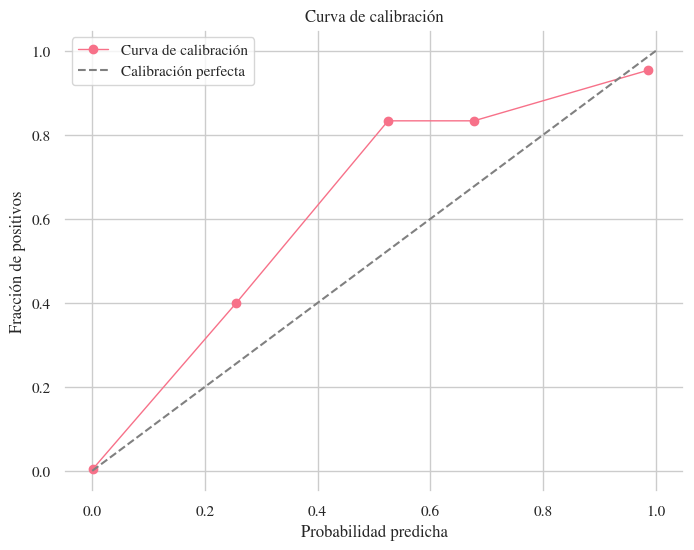

In [42]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=5, strategy='uniform')

# Grafica la curva de calibración
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Curva de calibración')
# Línea de referencia perfecta
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibración perfecta')

# Mejora la visualización
plt.xlabel('Probabilidad predicha')
plt.ylabel('Fracción de positivos')
plt.title('Curva de calibración')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [11]:
# Guardar modelo seleccionado
joblib.dump(tuned_xgboost, 'modelo_xg.joblib')

['modelo_xg.joblib']